### Example: Face Recognition

• As an example of support vector machines in action, let's take a look at the facial recognition problem.

• We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.

• A fetcher for the dataset is built into Scikit-Learn:

In [6]:
import matplotlib.pyplot as plt

In [5]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


• Let's plot a few of these faces to see what we're working with:

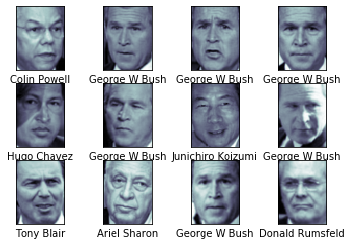

In [14]:
fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap = 'bone')
    axi.set(xticks=[], yticks=[],
           xlabel = faces.target_names[faces.target[i]])

• Each image contains [62×47] or nearly 3,000 pixels.

• We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (see In Depth: Principal Component Analysis) to extract 150 fundamental components to feed into our support vector machine classifier.

• We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [15]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

• For the sake of testing our classifier output, we will split the data into a training and testing set:

In [16]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                               random_state=42)

• Finally, we can use a grid search cross-validation to explore combinations of parameters.

• Here we will adjust C (which controls the margin hardness) and gamma (which controls the size of the radial basis function kernel), and determine the best model:

In [33]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C' : [1, 5, 10, 50],
             'svc__gamma' : [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, cv=5, iid=False)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 38s, sys: 32.1 s, total: 2min 10s
Wall time: 44.5 s
{'svc__C': 5, 'svc__gamma': 0.001}


• The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

• Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [34]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

• Let's take a look at a few of the test images along with their predicted values:

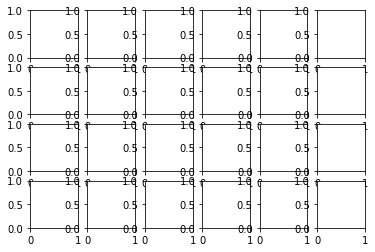

In [35]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    